# Meteor Project - Spherical KDE (attempt)

This script is not finished yet. But hey, let's see how progress is done! Or is it?

In [1]:
!pip install spherical_kde

You should consider upgrading via the '/Users/thomas/Python-Envs/python3.10.4/bin/python3.10 -m pip install --upgrade pip' command.


In [2]:
# Importing libraries
from matplotlib import pyplot as plt
import matplotlib.animation
import numpy as np
import pandas as pd

import datetime
import math
import os

# Load SPICE kernels
import spiceypy
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/fk/earth_sun.tf")

# Read in the meteor data
df_orbit_compl = pd.read_csv("meteor_data/meteor_compl.csv",
                             index_col=0)
df_orbit_error = pd.read_csv("meteor_data/meteor_error.csv",
                             index_col=0)

df_radiants = pd.concat([df_orbit_compl[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]],
                         df_orbit_error[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]]])

# Now filter
df_radiants = df_radiants.loc[(df_radiants["Vg"]>=11) & (df_radiants["Vg"]<=73)].copy()

# Convert to radians
df_radiants.loc[:, "RA_rad"] = np.radians(df_radiants["RA"])
df_radiants.loc[:, "DECL_rad"] = np.radians(df_radiants["DECL"])

# First we add a datetime object column:
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: datetime.datetime(year=int(x["Yr"]),
                                                  month=int(x["Mn"]),
                                                  day=math.floor(x["Dayy"])),
                                                  axis=1)

# Add now the day's fraction
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: x["datetime"] + datetime.timedelta(days=x["Dayy"]%1), axis=1)

# Add a Day of Year (DOY) column, based on the datetime column
df_radiants.loc[:, "doy"] = df_radiants.datetime.dt.day_of_year.copy()

# Compute emphermis time
df_radiants.loc[:, "ET"] = \
    df_radiants.apply(lambda x: spiceypy.utc2et(x["datetime"].strftime("%Y-%m-%dT%H:%M:%S")),
                                                axis=1)

In [3]:
# This function takes the RA and DEC values, given in J2000 and converts them in our new
# coordiante system called "EARTH_SUN".
def j2000_2_earthr(ra_radians, dec_radians, et):

    # Convert J2000 into a 3D vector
    rectan = spiceypy.radrec(1.0, ra_radians, dec_radians)

    # Compute a matrix that converts a vector in J2000 to EARTH_SUN
    tf_matrix = spiceypy.pxform("J2000", "EARTH_SUN", et)

    # Apply the transformation on the vector, and convert the resulting vector back to RA / DEC
    rectan_t = tf_matrix.dot(rectan)
    _, ra_earthr_radians, dec_earthr_radians = spiceypy.recrad(rectan_t)
    
    return ra_earthr_radians, dec_earthr_radians

In [4]:
# Add 2 new columns that contain RA and DEC values in EARTH_SUN
df_radiants.loc[:, "RA_earthr_rad"] = \
    df_radiants.apply(lambda x: j2000_2_earthr(x["RA_rad"], x["DECL_rad"], x["ET"])[0], axis=1)

df_radiants.loc[:, "DECL_earthr_rad"] = \
    df_radiants.apply(lambda x: j2000_2_earthr(x["RA_rad"], x["DECL_rad"], x["ET"])[1], axis=1)

# Add a column for the plot
df_radiants.loc[:, 'RA_earthr_rad4plot'] = \
    df_radiants['RA_earthr_rad'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

In [5]:
X_train = df_radiants[["RA_earthr_rad4plot", "DECL_earthr_rad"]].copy()

In [6]:
X_train.sort_values(by="DECL_earthr_rad", ascending=False)

,RA_earthr_rad4plot,DECL_earthr_rad
662404,-2.116727,1.569014
250635,-0.007344,1.568961
609514,-0.914334,1.568041
649942,-0.231998,1.567938
836838,3.084609,1.567730
...,...,...
403138,-0.376101,-1.556390
483867,-2.060803,-1.558162
478800,1.945025,-1.558411
491045,-0.963595,-1.559468


In [7]:
X_train_array = X_train.values
X_train_array = X_train_array[:10000]

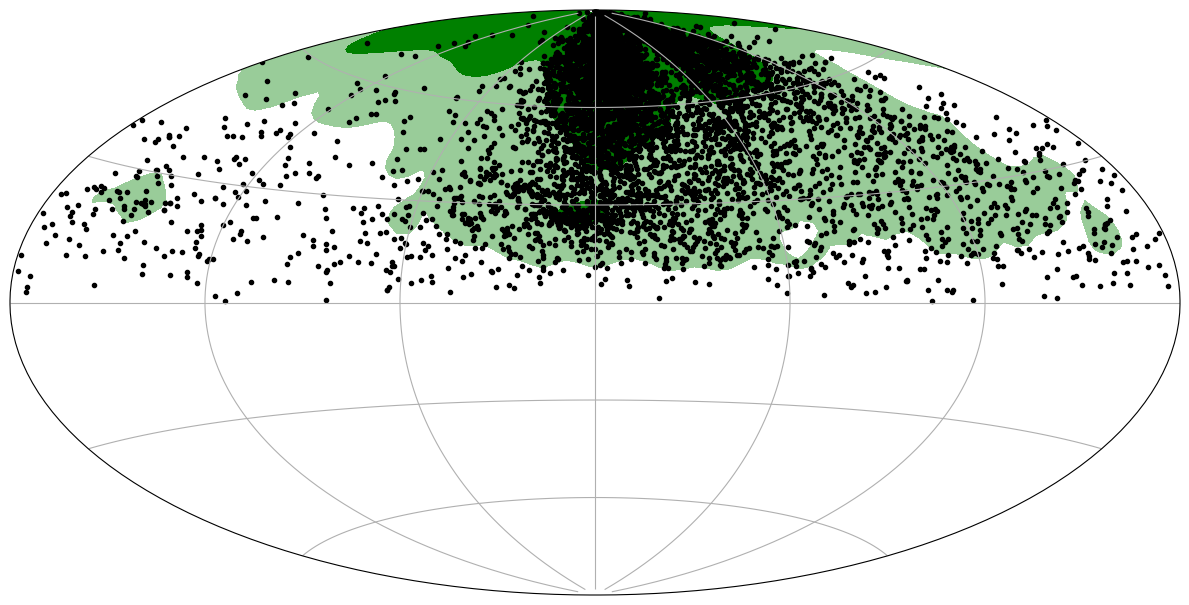

In [8]:
import numpy
from spherical_kde import SphericalKDE
import matplotlib.pyplot as plt
import cartopy.crs

fig = plt.figure(figsize=(12, 8))

# Add aitoff projection
plt.subplot(projection=cartopy.crs.Aitoff())

# Generate some samples centered on (1,1) +/- 0.3 radians
kde_green = SphericalKDE(X_train_array[:, 0], X_train_array[:, 1])

ax=plt.gca()

ax.gridlines()
kde_green.plot(ax, 'g')
kde_green.plot_samples(ax)

# Save to plot
fig.tight_layout()
plt.show()

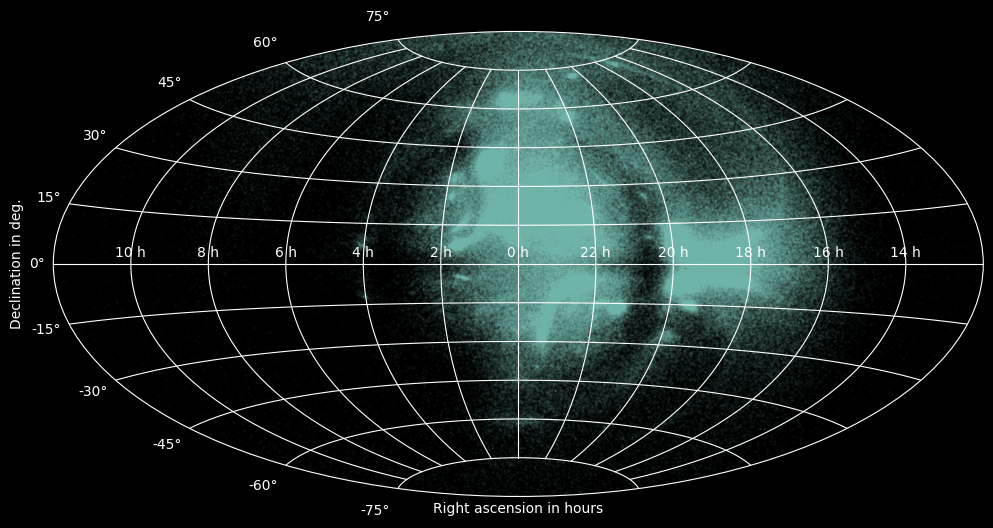

In [9]:
# Add some styles
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 8))

# Add aitoff projection
plt.subplot(projection="aitoff")

# Get axes
ax = plt.gca()

# Plot the radiants
cr = plt.scatter(X_train.values[:, 0], \
                 X_train.values[:, 1], linestyle='None', \
                 s=1, alpha=0.03)

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Add a grid
plt.grid(True)

plt.show()